In [172]:
# 包导入
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
# 数据生成的参数设置
# #
hour_rate = [0.23, 0.12, 0.09, 0.10, 0.07, 0.12, 0.21, 0.23, 0.45, 0.58, 0.34, 0.28, 
             0.67, 0.65, 0.45, 0.29, 0.24, 0.19, 0.38, 0.67, 0.73, 0.66,0.43, 0.22]
people = 1000
down_flow = 5000.0
up_flow = 100.0
file_path = "data.tfrecord"

In [ ]:
# 数据处理
# 验证小区上的流量，标签为小区下一个小时流量
# y_true为小区下个小时的流量
# 数据集为[24,4]的张量，将([i,3]+[i,4])=y_train[]
# 数据为：平均人数，最大人数，上行流量，下行流量，总流量（标签）
# 用于训练时总流量要向后移动一小时
# #

# 写数据到TFrecord文件
# #
# 生成首个数据，接下来的数据在前23小时上加一小时
first_day = np.zeros(120)
all_day = np.zeros(120000)
for i in range(0, 24):
    avg_people = hour_rate[i%24] * random.randint(30,80) * people / 10 
    max_people = avg_people * random.randint(20, 40) / 10
    down_f = hour_rate[i%24] * random.randint(30,80) * down_flow / 10
    up_f = hour_rate[i%24] * random.randint(30, 80) *  up_flow / 10
    first_day[i*5] = avg_people
    first_day[i*5+1] = max_people
    first_day[i*5+2] = up_f
    first_day[i*5+3] = down_f
    first_day[i*5+4] = up_f + down_f

# 储存第一组数据到总数据数组
for i in range(0, 120):
    all_day[i] = first_day[i] 

pre_day = first_day
for j in range(1, 1000):
    next_day = np.zeros(120)
    for m in range(0, 115):
        next_day[m] = pre_day[m+5]
        #输入新加的5个数据
        avg_people = hour_rate[j%24] * random.randint(30,80) * people / 10 
        max_people = avg_people * random.randint(20, 40) / 10
        down_f = hour_rate[j%24] * random.randint(30,80) * down_flow / 10
        up_f = hour_rate[j%24] * random.randint(30, 80) *  up_flow / 10
        next_day[115] = avg_people
        next_day[116] = max_people
        next_day[117] = up_f
        next_day[118] = down_f
        next_day[119] = up_f + down_f
    for n in range(0, 120):
        all_day[j*120+n] = next_day[n]
    pre_day = next_day
# 写入数据
with tf.io.TFRecordWriter(file_path) as files:
    # 第一个数据的写入
    example_first = tf.train.Example(
        features=tf.train.Features(
            feature={
                "data": tf.train.Feature(
                    float_list=tf.train.FloatList(value=all_day))
                }))
    files.write(example_first.SerializePartialToString())
    


In [ ]:
# 读数据函数,返回解析后的结果
def read_datas(filepath):
    feature_description = {
        "data": tf.io.VarLenFeature(dtype=float)
    }

    file_dataset = tf.data.TFRecordDataset(filepath).batch(5)

    for serialized_example in file_dataset:
        parsed_example = tf.io.parse_example(serialized_example,                                                                                                       feature_description)
    
    return parsed_example

In [ ]:
# 数组归一化
def maxminnorm(array):
    maxcols = array.max(axis=0)
    mincols = array.min(axis=0)
    data_shape = array.shape
    data_rows = data_shape[0]
    data_cols = data_shape[1]
    t = np.empty((data_rows,data_cols))
    for i in range(data_cols):
        t[:,i]=(array[:,i]-mincols[i])/(maxcols[i]-mincols[i])
    return t

In [ ]:
# 读取数据并简单处理
datas = read_datas(file_path)["data"].values
reshape_datas = tf.reshape(datas, [24000,5])
x_data = reshape_datas[0:24000,0:4]
x_array = np.array(x_data)
y_data = tf.reshape(reshape_datas[0:24000,4], [24000,1])
y_array = np.array(y_data)

x_f = maxminnorm(x_array)
y_f = maxminnorm(y_array)
print(x_f)
print(y_f)

In [ ]:
# 流量图的绘制
y = np.zeros(shape=[1000])
for i in range(0, 1000):
    y_all_data = np.zeros(shape=[1])
    y_all_data[0] = y_array[i*24+1]
    y[i] = y_all_data

x = np.linspace(1,1000,1000)
plt.plot(x,y)
plt.show()

In [ ]:
# 特征数据的处理
X_all = np.zeros(shape=[1000,1,24,4,1])
for g in range(0, 1000):
    data_4 = np.zeros(shape=[1,24,4,1])
    for i in range(0, 24):
        for j in range(0, 4):
            data_4[0,i,j,0] = x_f[i+24*g,j]
    X_all[g] = data_4

print(X_all)

In [ ]:
# y_all是每个数据张量的下一个数据张量的第一行第五列
Y_all = np.zeros(shape=[1000,1])
for i in range(0, 1000):
    y_all_data = np.zeros(shape=[1])
    y_all_data[0] = y_f[i*24+1]
    Y_all[i] = y_all_data
print(Y_all)

In [ ]:
#############################################模型构建####################################################################

In [192]:
# CNN模块创建
# 步频为1，输入输出的空间维度不变[24,4]
udn_model = keras.models.Sequential([
    keras.layers.Conv2D(128, 2, activation="relu", padding="same",
                         input_shape=[24, 4, 1]),
    keras.layers.Conv2D(64, 2, activation="relu", padding="same"),
    keras.layers.Conv2D(32, 2, activation="relu", padding="same"),
    keras.layers.Conv2D(32, 2, activation="relu", padding="same"),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(16, 2, activation="relu", padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="relu")
])

udn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 24, 4, 128)        640       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 24, 4, 64)         32832     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 4, 32)         8224      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 24, 4, 32)         4128      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 2, 32)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 12, 2, 16)         2064      
_________________________________________________________________
flatten_6 (Flatten)          (None, 384)              

In [193]:
# 损失函数为负对数似然（negative log likelihood）
MeanAbsoluteError = keras.losses.MeanAbsoluteError()
# 负对数似然（negative log likelihood）
def negative_log_likelihood(y_true, y_pred, eps=1e-15):
    p = keras.backend.clip(y_pred, eps, 1-eps)
    loss = keras.backend.sum(-y_true * keras.backend.log(p) - (1-y_true) * keras.backend.log(1-p))
    return keras.backend.mean(loss)


losses = MeanAbsoluteError

In [194]:
# 编译模块
Adam = keras.optimizers.Adam(learning_rate=5e-6)
metrics = keras.metrics.Accuracy()

udn_model.compile(
    loss=losses,
    optimizer=Adam,
)

In [195]:
# 训练模块
# 在训练时运用mini-batch方法进行小批量梯度、
# 对每个小时进行预测
# callbacks设置
callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = []

for i in range(0, 700):
    x_train = X_all[i]
    y_train = Y_all[i]
    one_history = udn_model.fit(
        x=x_train,
        y=y_train,
        callbacks=[callbacks],
    )
    history.append(one_history.history)


ample - loss: 0.2518
Train on 1 samples
1/1 [==============================] - 0s 22ms/sample - loss: 0.8039
Train on 1 samples
1/1 [==============================] - 0s 18ms/sample - loss: 0.7034
Train on 1 samples
1/1 [==============================] - 0s 21ms/sample - loss: 0.4240
Train on 1 samples
1/1 [==============================] - 0s 23ms/sample - loss: 0.2447
Train on 1 samples
1/1 [==============================] - 0s 22ms/sample - loss: 0.1087
Train on 1 samples
1/1 [==============================] - 0s 23ms/sample - loss: 0.1508
Train on 1 samples
1/1 [==============================] - 0s 22ms/sample - loss: 0.1053
Train on 1 samples
1/1 [==============================] - 0s 23ms/sample - loss: 0.0924
Train on 1 samples
1/1 [==============================] - 0s 21ms/sample - loss: 0.0415
Train on 1 samples
1/1 [==============================] - 0s 24ms/sample - loss: 0.0712
Train on 1 samples
1/1 [==============================] - 0s 23ms/sample - loss: 0.0019
Train on 1 

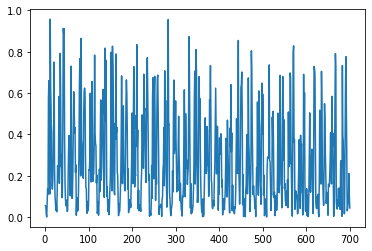

In [196]:
result = np.zeros(shape=[700,1])
re = -1 
for items in history:
    re = re + 1
    result[re] = items["loss"]

x = np.linspace(1,700,700)
plt.plot(x,result)
plt.show()

In [ ]:
# 验证模块
for i in range(700, 900):
    x_eva = X_all[i]
    y_eva = Y_all[i] 
    udn_model.evaluate(
        x=eva_x,
        y=eva_y
    )

In [ ]:
# 测试模块
for i in range(900, 1000):
    test_x = train_4[i] 
    result = udn_model.predict(
        test_x,
    )

In [ ]:
print(result)